# 1.올바른 시간 데이터 순서 확인

In [1]:
import pandas as pd

file_path = r'D:\MusicTrendAnalysis\data\daegeun_time_data.csv'
data = pd.read_csv(file_path)

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date').reset_index(drop=True)

print(data.head())

   Unnamed: 0       date  Rank   Runtime  Weekly Views   n_score  g_score  \
0           0 2023-09-24     1 -0.733963      2.119452  0.942971     1.00   
1         123 2023-09-24   130  1.052141     -1.011885  0.104623     0.03   
2         124 2023-09-24   131  0.947076      0.413551  0.509538     0.30   
3         125 2023-09-24   132 -1.338086     -0.282185  0.496288     0.15   
4         126 2023-09-24   133 -0.024775      0.127099  0.250688     0.10   

   ky_chart_on  KoreanMovies  Dance  ...  Ballad  Soul  Rock  Pop  \
0            0             0      1  ...       0     0     0    0   
1            1             0      0  ...       1     0     0    0   
2            0             0      0  ...       0     0     1    0   
3            0             0      0  ...       0     0     0    1   
4            0             0      0  ...       0     0     1    0   

   season_autumn  season_spring  season_summer  season_winter  Previous_Rank  \
0              1              0           

# 2.지연기능 생성

In [2]:
lag_features = ['Rank', 'Weekly Views', 'n_score', 'g_score']

for feature in lag_features:
    data[f'{feature}_lag_1'] = data[feature].shift(1)
    data[f'{feature}_lag_2'] = data[feature].shift(2)
    data[f'{feature}_lag_3'] = data[feature].shift(3)

data = data.dropna().reset_index(drop=True)

print(data[['date', 'Rank', 'Rank_lag_1', 'Rank_lag_2', 'Rank_lag_3']].head())

        date  Rank  Rank_lag_1  Rank_lag_2  Rank_lag_3
0 2023-09-24   132       131.0       130.0         1.0
1 2023-09-24   133       132.0       131.0       130.0
2 2023-09-24   134       133.0       132.0       131.0
3 2023-09-24   135       134.0       133.0       132.0
4 2023-09-24   136       135.0       134.0       133.0


In [3]:
data[['Rank_lag_1', 'Rank_lag_2', 'Rank_lag_3']].describe()

,Rank_lag_1,Rank_lag_2,Rank_lag_3
count,9840.000000,9840.000000,9840.000000
mean,100.007724,100.016159,100.008943
std,57.996880,57.995206,58.003108
min,1.000000,1.000000,1.000000
25%,49.000000,49.000000,49.000000
50%,100.000000,100.000000,100.000000
75%,150.000000,150.000000,150.000000
max,200.000000,200.000000,200.000000


# 4.LSTM모델 구축 및 교육

In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prepare the data for the LSTM model
# Define the input features and the target variable (Rank)
features = ['Weekly Views', 'n_score', 'g_score', 'Rank_lag_1', 'Rank_lag_2', 'Rank_lag_3']
target = 'Rank'

# Split data into input (X) and output (y)
X = data[features].values
y = data[target].values

# Reshape the input to be 3D for LSTM: (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 1 timestep for each input sample

X_train = X[:-500]
y_train = y[:-500]

X_test = X[-500:]
y_test = y[-500:]


In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

def build_lstm_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer for Rank prediction

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

epochs = 100


# 10.최적의 하이퍼파라미터로 최종 모델 학습

Epoch 1/100


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 12234.3623 - val_loss: 9955.5742
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9132.3633 - val_loss: 8255.0811
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7606.3110 - val_loss: 6912.3838
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6499.6108 - val_loss: 5826.0234
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5507.7871 - val_loss: 4900.7344
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4672.9053 - val_loss: 4128.9785
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3931.2788 - val_loss: 3490.3906
Epoch 8/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3335.6069 - val_loss: 2939.5823
Epoch 9/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2818.0093 - val_loss: 2473.0679
Epoch 10/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2428.6213 - val_loss: 2090.8828
Epoch 11/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2037.0398 - val_lo

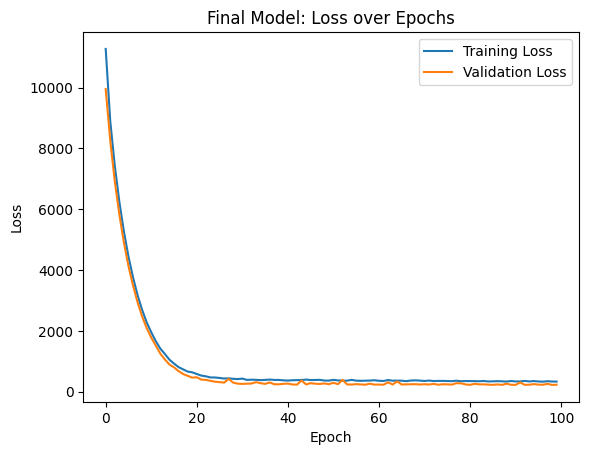

In [6]:
# 스텝 3

# Extract the best hyperparameters
best_params = {'units': 60, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'val_loss': 0.007861444726586342}
best_units = best_params['units']
best_dropout = best_params['dropout_rate']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']

# Train the final model with optimal hyperparameters
final_model = build_lstm_model(units=best_units, dropout_rate=best_dropout, learning_rate=best_learning_rate)
history = final_model.fit(X_train, y_train, epochs=epochs, batch_size=best_batch_size, validation_split=0.2)

# Plot the final model's training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Final Model: Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# 11.최적의 하이퍼파라미터를 사용하여 모델 재교육

Epoch 1/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12027.6104
Epoch 2/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8890.6602
Epoch 3/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7026.9136
Epoch 4/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5740.9658
Epoch 5/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4636.8140
Epoch 6/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3755.1252
Epoch 7/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3115.5745
Epoch 8/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2485.9138
Epoch 9/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2019.4147
Epoch 10/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1717.8856
Epoch 11/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1419.5150
Epoch 12/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1178.8595
Epoch 13/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 971.1102
Epoch 14/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 804.7348
Ep

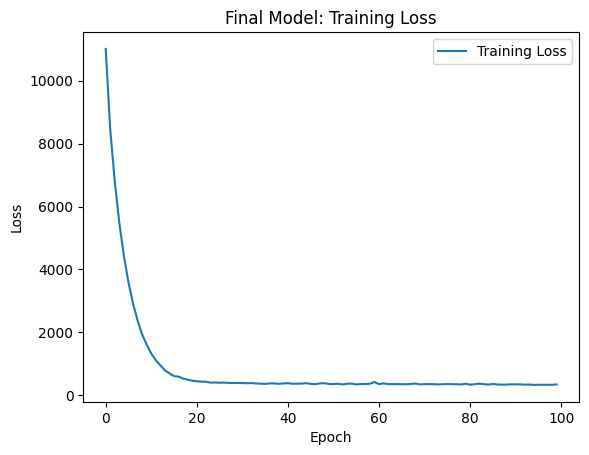

In [7]:
# Build the final model with optimal hyperparameters
final_model = build_lstm_model(units=60, dropout_rate=0.2, learning_rate=0.001)

# Train the model on the entire dataset (no validation split)
final_history = final_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Plot the training loss to verify training stability
plt.plot(final_history.history['loss'], label='Training Loss')
plt.title('Final Model: Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# 12.테스트 데이터에 대한 예측하기

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


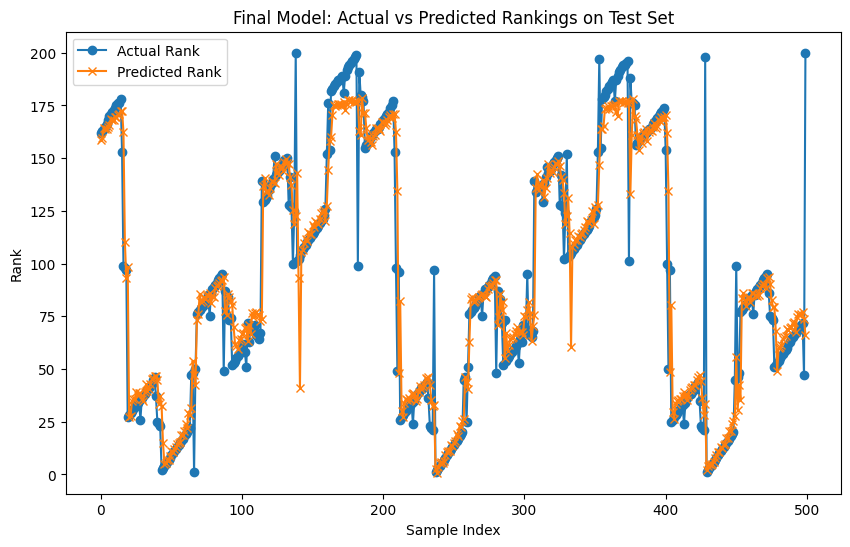

In [8]:
# Assuming you have test data (replace this with your actual test dataset)
# Preprocess test data in the same way as training data
# test_X = preprocess_test_data(test_data)

# Make predictions on the test set
test_predictions = final_model.predict(X_test)  # Replace 'X' with your test data 'test_X'


# Compare predicted and actual rankings on the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.reshape(-1, 1), label='Actual Rank', marker='o')  # Actual rankings (first 100 data points)
plt.plot(test_predictions, label='Predicted Rank', marker='x')  # Predicted rankings (first 100 data points)
plt.xlabel('Sample Index')
plt.ylabel('Rank')
plt.title('Final Model: Actual vs Predicted Rankings on Test Set')
plt.legend()
plt.show()

# 13. 모델 성능 및 평가

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(y_test.reshape(-1, 1), test_predictions)
mae = mean_absolute_error(y_test.reshape(-1, 1), test_predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 353.595573891989
Root Mean Squared Error (RMSE): 18.804137148297684
Mean Absolute Error (MAE): 9.3365430727005


In [10]:
final_model.save('lstm_model.keras')